# Color Commons

## Abstract

## Quick Statistics

- Total amount of texts: 8022
- **Top 5 Colors:** Red, Blue, Green, Yellow, Pink

- **How many times 'secret' was texted:**
- highly engaged users (over 15 texts)

- 
- unique users

- repreat users

- highly engaged users (over 15 texts)

- user groups/clusters
- peak use -- times of day and week

## Contents
- 1.0 User Participation
- 2.0 Message Content



In [108]:
# Basic setup

import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
import json
import difflib
import pickle
import re
from collections import Counter
import seaborn as sb

# Read in a prepared dataset
df = pd.read_csv('../data/napa_with_datetime.csv')
df.index = pd.to_datetime(df.datetime)
df.index.tz_localize('UTC').tz_convert('US/Eastern')
df['date'] = [x.date() for x in df.index]
df['hour'] = [x.hour for x in df.index]
df = df[['id', 'Body', 'SentDate', 'Status', 'datetime', 'date', 'weekday', 'hour']]

## 2.0 User Participation


In [2]:
# Total messages
print('Total messages = {}\n'.format(len(df)))

Total messages = 8022



In [3]:
# Count of unique users
print('# of unique users: {}\n'.format(len(set(df.id))))

# of unique users: 464



In [4]:
# Count of repeat users
print('# of repeat users: {}\n'.format(sum(df.id.value_counts() > 1)))

# of repeat users: 374



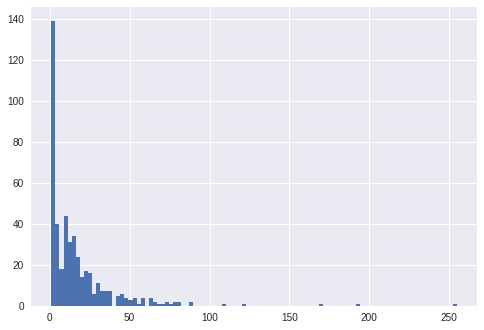

count    464.000000
mean      17.288793
std       24.151309
min        1.000000
25%        2.000000
50%       11.000000
75%       22.000000
max      255.000000
Name: id, dtype: float64

In [5]:
# A two-panel plot showing user frequency
plt.hist(df.id.value_counts(), bins = 100)
plt.show()
df.id.value_counts().describe()

In [6]:
# Read in the pickled dataset
with open('../data/napa.pickle', 'rb') as f:
    ccdf = pickle.load(f)
    
ccdf.columns = ['min_date', 'ct']
ccdf = ccdf.reset_index()

ccdf['pct'] = ccdf.ct/sum(ccdf.ct)
ccdf['cumpct'] = np.cumsum(ccdf.pct)

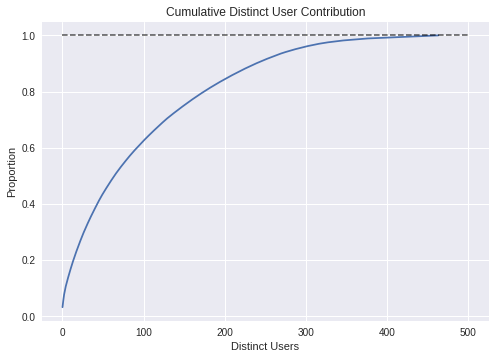

In [7]:
# Cumulative plot showing user contribution
plt.plot(ccdf.cumpct)
plt.plot([0, 500], [1, 1], color='k', linestyle='--', linewidth=2, alpha=0.5)
plt.xlabel('Distinct Users')
plt.ylabel('Proportion')
plt.title('Cumulative Distinct User Contribution')
plt.show()

In [8]:
# Use the index (a date-time) to create a column with the weekday names
df['weekday_name'] = df.index.weekday_name

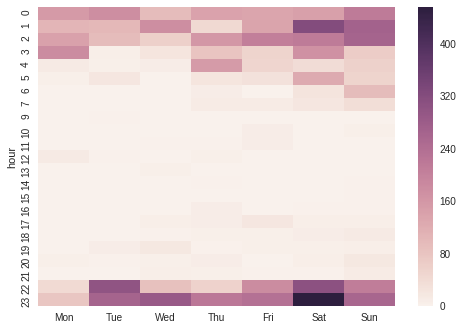

In [9]:
def make_hour_weekday_heatmap(_df, _aggfunc):
    # Use pandas pivot table to sum up counts by weekday and hour
    # This creates a 2D dataframe containing the counts
    weekday_hour = pd.pivot_table(_df, values='id', index=['hour'], columns=['weekday'], aggfunc=_aggfunc, fill_value=0)

    # Overwrite column names with abbrev
    weekday_hour.columns = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

    # Create a heat plot with our 2D dataframe
    sb.heatmap(weekday_hour)
    plt.show()

make_hour_weekday_heatmap(df, len)

Saturday at 11p is the most popular time based on absolute counts.  We have some heavy users, which might be biasing our visualization.  We can approach this a few ways:

    (1) plot only the initial text by a user
    (2) only allow a user to contribute one text per grid cell
    (3) normalize the users text count

   id           Body                 SentDate    Status             datetime  \
0   1          White  2017-03-01 19:12:27 UTC  received  2017-03-01 19:12:27   
1   2            red  2017-02-26 00:13:07 UTC  received  2017-02-26 00:13:07   
2   3     Lime green  2017-03-31 01:15:01 UTC  received  2017-03-31 01:15:01   
3   4          Green  2017-03-18 00:14:30 UTC  received  2017-03-18 00:14:30   
4   5  bright yellow  2017-02-19 22:43:13 UTC  received  2017-02-19 22:43:13   

         date  weekday  hour weekday_name  
0  2017-03-01        2    19    Wednesday  
1  2017-02-26        6     0       Sunday  
2  2017-03-31        4     1       Friday  
3  2017-03-18        5     0     Saturday  
4  2017-02-19        6    22       Sunday  


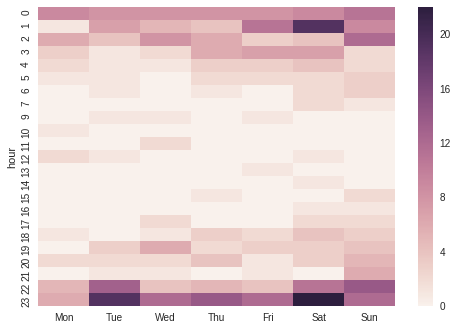

In [10]:
# (1) plot only the initial text by a user
only_first_time_user = df.groupby('id').first().reset_index() # better check to make sure that actually works
print(only_first_time_user.head())

make_hour_weekday_heatmap(only_first_time_user, len)

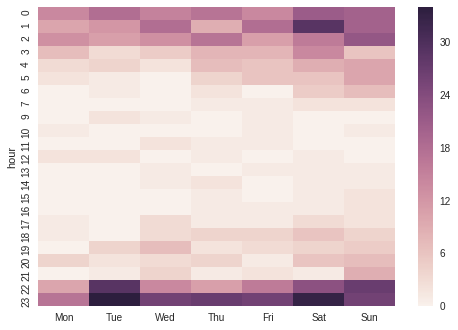

In [11]:
# (2) only allow a user to contribute one text per grid cell
def count_unique(col):
    # a quick function to return the count of unique values
    return(len(set(col)))

# Create the heatmap with our custom count_unique function
make_hour_weekday_heatmap(df, count_unique)

These all look sort of the same.  I imagine the third will look similar, so I am not going to bother making it.

In [12]:
# Top 5 colors
print('Top 5 Colors:\n{}\n'.format(df.Body.str.lower().value_counts().head(5)))

# 'secret' message
print('Count of "secret" texts: {}'.format(sum(df.Body.str.lower() == 'secret')))

# 'poop' message
print('Count of "poop" texts: {}'.format(sum(df.Body.str.lower() == 'poop')))

Top 5 Colors:
red       710
blue      632
green     539
yellow    444
pink      403
Name: Body, dtype: int64

Count of "secret" texts: 163
Count of "poop" texts: 29


## Groups or Individuals

In [13]:
def count_unique(input_list):
    return Counter(input_list).items()

ctr = count_unique(['a', 'b', 'a'])

df.groupby('id').aggregate({'date': [count_unique, len, min, max]}).sort_values(by=('date', 'len'), ascending=False)

date                   \
                                          count_unique  len         min   
id                                                                        
433  ((2017-03-15, 9), (2017-02-23, 4), (2017-02-26...  255  2017-02-19   
172  ((2017-03-19, 1), (2017-03-18, 4), (2017-03-01...  193  2017-02-23   
432  ((2017-03-25, 12), (2017-03-24, 12), (2017-03-...  170  2017-03-05   
10   ((2017-03-24, 1), (2017-02-23, 2), (2017-02-20...  122  2017-02-20   
430  ((2017-02-19, 18), (2017-02-21, 29), (2017-02-...  109  2017-02-19   
428  ((2017-02-19, 4), (2017-02-21, 30), (2017-02-1...   89  2017-02-18   
252  ((2017-03-24, 6), (2017-03-23, 55), (2017-03-3...   89  2017-03-05   
217  ((2017-02-23, 1), (2017-02-15, 1), (2017-02-19...   82  2017-02-15   
62   ((2017-02-19, 17), (2017-02-16, 11), (2017-02-...   82  2017-02-15   
362  ((2017-03-17, 2), (2017-03-10, 4), (2017-03-18...   79  2017-02-25   
157  ((2017-03-10, 18), (2017-02-23, 21), (2017-02-...   78  2017-02-17   
219  ((2017-02-26, 9), (2017-02-25, 44), (2017-02-2...   77  2017-02-24   
182  ((2017-02-16, 4), (2017-02-17, 1), (2017-03-03...   73  2017-02-16   
164               ((2017-02-19, 45), (2017-02-20, 28))   73  2017-02-19   
184                                 ((2017-03-30, 70))   70  2017-03-30   
464  ((2017-03-10, 3), (2017-03-28, 10), (2017-02-2...   68  2017-02-25   
449                                 ((2017-02-18, 67))   67  2017-02-18   
178  ((2017-03-15, 2), (2017-02-19, 50), (2017-02-2...   66  2017-02-19   
171  ((2017-03-02, 14), (2017-03-07, 4), (2017-03-0...   64  2017-03-01   
116  ((2017-03-07, 12), (2017-03-01, 5), (2017-02-2...   63  2017-02-24   
120                                 ((2017-03-30, 63))   63  2017-03-30   
114               ((2017-03-18, 51), (2017-03-31, 11))   62  2017-03-18   
40                ((2017-02-20, 46), (2017-03-11, 13))   59  2017-02-20   
125                                 ((2017-02-19, 59))   59  2017-02-19   
111  ((2017-03-02, 25), (2017-03-16, 5), (2017-03-0...   59  2017-03-01   
4    ((2017-02-27, 28), (2017-03-10, 1), (2017-03-1...   59  2017-02-26   
121  ((2017-02-16, 1), (2017-02-15, 5), (2017-03-06...   55  2017-02-14   
373  ((2017-03-04, 4), (2017-03-10, 1), (2017-02-19...   54  2017-02-19   
129                                 ((2017-02-25, 53))   53  2017-02-25   
18                                  ((2017-03-19, 53))   53  2017-03-19   
..                                                 ...  ...         ...   
298                                  ((2017-02-14, 1))    1  2017-02-14   
299                                  ((2017-02-17, 1))    1  2017-02-17   
356                                  ((2017-02-15, 1))    1  2017-02-15   
358                                  ((2017-03-07, 1))    1  2017-03-07   
360                                  ((2017-02-14, 1))    1  2017-02-14   
363                                  ((2017-02-22, 1))    1  2017-02-22   
407                                  ((2017-02-23, 1))    1  2017-02-23   
167                                  ((2017-02-15, 1))    1  2017-02-15   
168                                  ((2017-02-20, 1))    1  2017-02-20   
404                                  ((2017-03-17, 1))    1  2017-03-17   
177                                  ((2017-02-15, 1))    1  2017-02-15   
59                                   ((2017-02-16, 1))    1  2017-02-16   
56                                   ((2017-03-03, 1))    1  2017-03-03   
186                                  ((2017-03-04, 1))    1  2017-03-04   
392                                  ((2017-02-24, 1))    1  2017-02-24   
391                                  ((2017-02-21, 1))    1  2017-02-21   
188                                  ((2017-02-15, 1))    1  2017-02-15   
21                                   ((2017-02-15, 1))    1  2017-02-15   
22                                   ((2017-02-19, 1))    1  2017-02-19   
201                                  ((2017-03-29, 1))    1  2017-03-29   


In [14]:
ordered_ids = df.sort_values(by='datetime').id

In [72]:
grouped = df.groupby('date')

colors_by_date = {}

for name, group in grouped:
    colors_by_date[name.strftime("%Y%m%d")] = group.Body.as_matrix()

In [154]:
import pprint
colors_dict = {}
colors_dict['name'] = 'dates'
colors_dict['children'] = []

grouped = df.groupby('date')

for name, group in grouped:
    dates_dict = {}
    dict_list = []
    for (value, count) in group.Body.value_counts().to_dict().items():
        if count < 2:
            continue
        dict_list.append({'name': re.sub(r"\s+", "", value), 'size': int(count)})
    dates_dict['name'] = name.strftime("%Y-%m-%d")
    dates_dict['children'] = dict_list
    colors_dict['children'].append(dates_dict)

with open('../data/dates.json', 'w') as f:
    f.write(json.dumps(colors_dict, indent = 4, ensure_ascii=False))

In [148]:
grouped = df.groupby('id')

colors_dict = {}
colors_dict['name'] = 'dates'
colors_dict['children'] = []

for name, group in grouped:
    dates_dict = {}
    dict_list = []
    for (value, count) in group.Body.value_counts().to_dict().items():
        if count < 2:
            continue
        dict_list.append({'name': re.sub(r"\s+", "", value), 'size': int(count)})
    dates_dict['name'] = int(name)
    dates_dict['children'] = dict_list
    colors_dict['children'].append(dates_dict)

with open('../data/user.json', 'w') as f:
    f.write(json.dumps(colors_dict, indent = 4, ensure_ascii=False))

In [94]:
color_map = pd.read_csv('../data/rgb.txt'
                        ,sep='\t'
                        ,skiprows=[0]
                        ,names = ['color', 'hex', 'unk'])[['color', 'hex']]

In [18]:
import random
#unique_days_ct = len(date_color_json.keys())
unique_days_ct = 2

colors_by_date_subset = {}
date1 = '20170218'
date2 = '20170216'
colors_by_date_subset[date1] = colors_by_date[date1]
colors_by_date_subset[date2] = colors_by_date[date2]

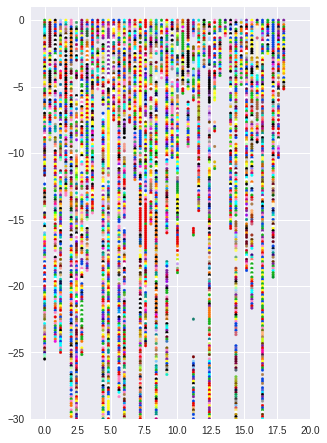

In [19]:
fig = plt.figure(figsize=[5,120]) # give plots a rectangular frame
ax = fig.add_subplot(111)
ax.set_aspect(1)
r = 0.1
x_val = 0
x_inc = 0.4
x_min = x_inc*unique_days_ct


for day, color_array in colors_by_date.items():
    for y, color in enumerate(color_array):
        try:
            clr = color_map[color_map.color == difflib.get_close_matches(color, color_map.color)[0]].hex.to_string(index=False)
            circle = plt.Circle((x_val, -y/6), r, color=clr) # create the circle with the color
        except:
            continue
        ax.add_artist(circle)
    x_val += x_inc
    
ax.set_xlim(-1, 20)
ax.set_ylim(-30, 1)
plt.show()